Rolling Regression:
We estimate a fixed-window linear regression where we regress one asset’s price (e.g. S&P 500 ETF) on the other (Dow Jones ETF) over a rolling window (e.g. 60 days). The slope coefficient is taken as the hedge ratio.

Kalman Filter:
We set up a state-space model where the hedge ratio (and intercept) are allowed to vary over time. The Kalman filter recursively updates these estimates as new data arrives.

<Figure size 2000x1500 with 0 Axes>

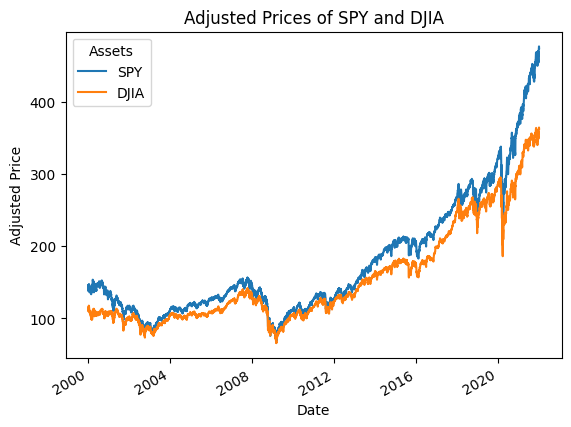

<Figure size 1500x700 with 0 Axes>

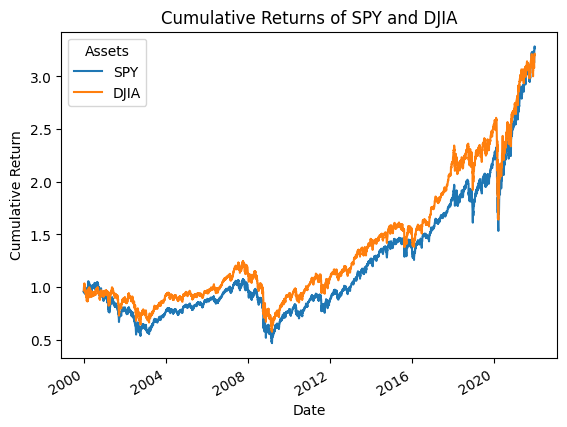

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Load SPY and DJIA data from CSV files
df_spy = pd.read_csv('spy.csv', parse_dates=['Date'], index_col='Date')
df_djia = pd.read_csv('djia.csv', parse_dates=['Date'], index_col='Date')

# Keep only the PX_LAST column and rename appropriately
df_spy = df_spy[['PX_LAST']].rename(columns={'PX_LAST': 'SPY'})
df_djia = df_djia[['PX_LAST']].rename(columns={'PX_LAST': 'DJIA'})

# Merge datasets based on Date
df = pd.merge(df_spy, df_djia, left_index=True, right_index=True, how='inner')

# Convert index to datetime format (if not already)
df.index = pd.to_datetime(df.index)

# --- Plot Adjusted Prices ---
plt.figure(figsize=(15, 7))
df.plot()
plt.legend(title="Assets")
plt.ylabel('Adjusted Price')
plt.title("Adjusted Prices of SPY and DJIA")
plt.show()

# --- Compute Daily Returns ---
df_returns = df.pct_change().dropna()  # Drop first NaN row

# --- Compute Cumulative Returns ---
df_cumulative = (1 + df_returns).cumprod()

# --- Plot Cumulative Returns ---
plt.figure(figsize=(15, 7))
df_cumulative.plot()
plt.legend(title="Assets")
plt.ylabel('Cumulative Return')
plt.title("Cumulative Returns of SPY and DJIA")
plt.show()


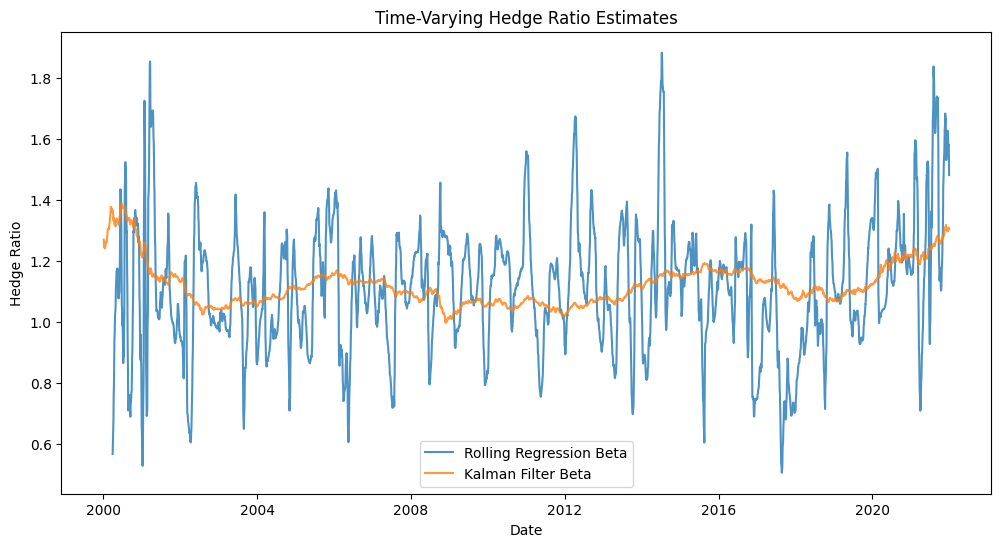

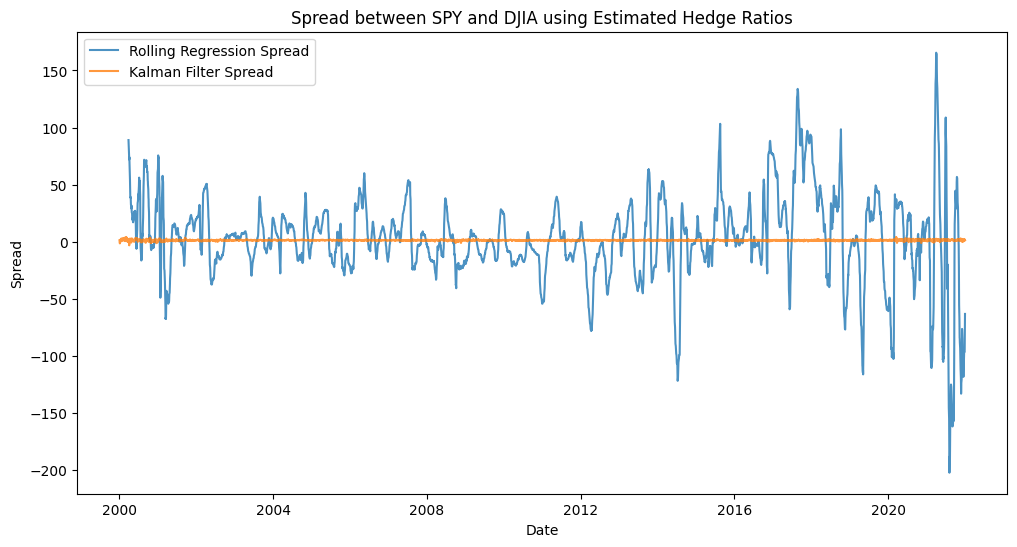

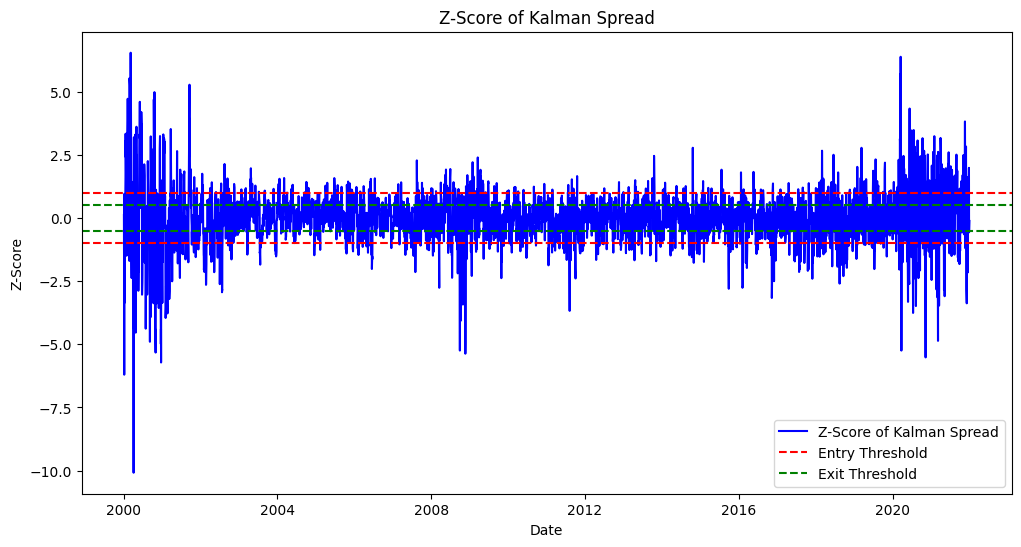

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS  # For rolling regression
from pykalman import KalmanFilter  # For Kalman filtering

# -------------------------------
# 1. Data Preparation
# -------------------------------
# Read SPY data
df_spy = pd.read_csv('spy.csv', parse_dates=['Date'])
df_spy = df_spy[['Date', 'PX_LAST']]
df_spy.rename(columns={'PX_LAST': 'SPY'}, inplace=True)

# Read DJI data
df_dji = pd.read_csv('djia.csv', parse_dates=['Date'])
df_dji = df_dji[['Date', 'PX_LAST']]
df_dji.rename(columns={'PX_LAST': 'DJIA'}, inplace=True)

# Merge the two datasets on the Date column
df = pd.merge(df_spy, df_dji, on='Date', how='inner')
df.set_index('Date', inplace=True)

# -------------------------------
# 2. Rolling Regression Approach
# -------------------------------
# Add a constant column for the regression intercept
df['const'] = 1

# Define the dependent variable (SPY) and independent variables (DJIA and constant)
y = df['SPY']
X = df[['DJIA', 'const']]

# Set the rolling window length (e.g., 60 trading days)
window = 60

# Fit a rolling OLS model
rolling_model = RollingOLS(endog=y, exog=X, window=window)
rolling_res = rolling_model.fit()

# Extract the time-varying hedge ratio (slope for DJIA)
df['beta_rolling'] = rolling_res.params['DJIA']

# Compute the spread using the rolling regression hedge ratio
df['spread_rolling'] = df['SPY'] - df['beta_rolling'] * df['DJIA']

# -------------------------------
# 3. Kalman Filter Approach
# -------------------------------
# The state-space model:
#   Observation equation: SPY_t = beta_t * DJIA_t + alpha_t + ε_t
#   State equation: [beta_t, alpha_t]' = [beta_(t-1), alpha_(t-1)]' + w_t
# where w_t ~ N(0, Q) and ε_t ~ N(0, R)

# Set the state noise parameter (tuning parameter)
delta = 1e-5  
trans_cov = delta / (1 - delta) * np.eye(2)  # Transition covariance matrix Q
obs_cov = 1.0  # Observation noise variance R (can be tuned)

# Build the design (observation) matrix for each time step: [DJIA, 1]
obs_mat = np.vstack([df['DJIA'].values, np.ones(len(df))]).T

# Initialize the Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat[:, np.newaxis, :],  # Shape (n_timesteps, 1, 2)
    transition_covariance=trans_cov,
    observation_covariance=obs_cov,
    initial_state_mean=[0, 0],
    initial_state_covariance=np.ones((2, 2))
)

# Run the filter on the SPY price series to estimate the state vector [beta, alpha]
state_means, state_covs = kf.filter(df['SPY'].values)

# Store the Kalman filter estimates in the DataFrame
df['beta_kalman'] = state_means[:, 0]
df['alpha_kalman'] = state_means[:, 1]

# Calculate the spread using the Kalman filter hedge ratio
df['spread_kalman'] = df['SPY'] - df['beta_kalman'] * df['DJIA']

# -------------------------------
# 4. Comparing the Two Methods
# -------------------------------
# Plot the hedge ratios estimated by both methods
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['beta_rolling'], label='Rolling Regression Beta', alpha=0.8)
plt.plot(df.index, df['beta_kalman'], label='Kalman Filter Beta', alpha=0.8)
plt.title('Time-Varying Hedge Ratio Estimates')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.show()

# Plot the spreads calculated by both methods
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['spread_rolling'], label='Rolling Regression Spread', alpha=0.8)
plt.plot(df.index, df['spread_kalman'], label='Kalman Filter Spread', alpha=0.8)
plt.title('Spread between SPY and DJIA using Estimated Hedge Ratios')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

# -------------------------------
# 5. Example: Generating Trading Signals
# -------------------------------
# Define a function to compute the z-score of a series
def zscore(series):
    return (series - series.mean()) / series.std()

# Compute z-scores for both spreads
df['zspread_rolling'] = zscore(df['spread_rolling'])
df['zspread_kalman'] = zscore(df['spread_kalman'])

# Define entry and exit thresholds (e.g., entry when |z| > 1, exit when |z| < 0.5)
entry_threshold = 1.0
exit_threshold = 0.5

# Plot the z-score of the Kalman spread along with thresholds
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['zspread_kalman'], label='Z-Score of Kalman Spread', color='blue')
plt.axhline(entry_threshold, color='red', linestyle='--', label='Entry Threshold')
plt.axhline(-entry_threshold, color='red', linestyle='--')
plt.axhline(exit_threshold, color='green', linestyle='--', label='Exit Threshold')
plt.axhline(-exit_threshold, color='green', linestyle='--')
plt.title('Z-Score of Kalman Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

# Note: To complete the strategy, you would implement logic to generate positions based on these thresholds,
# backtest the trades, and evaluate performance (including transaction costs and risk management).

